## Feature Scaling and Encoding.

## Import libraries

In [48]:
import sys

# Detect if running in Google Colab
in_colab = 'google.colab' in sys.modules

if in_colab:
    print("Running in Google Colab. Installing some required libraries...")
    !pip install category_encoders wandb shap tsfresh pyts sktime[all_extras] evalml featuretools imbalanced-learn pyarrow

In [49]:
# Basic Libraries & data manipulation
import os
from itertools import product
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Feature Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import category_encoders as ce # pip install category_encoders

# Feature Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

# Feature Engineering
# import tsfresh
# import featuretools
# from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Modelling & Evaluation
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
from wandb.keras import WandbCallback

# Wandb for tracking experiments
os.environ["WANDB_NOTEBOOK_NAME"] = "scaling_encoding.ipynb"
import wandb
from wandb.sklearn import plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve

# Import personal functions
import functions as func

In [50]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Import the data

In [51]:
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    # Restore de dataset from the parquet file
    df = pd.read_parquet('df_clean.parquet.gzip')
    # comp_df = pd.read_csv('/content/drive/MyDrive/competition.csv')
else:
    filename = 'df_clean.parquet.gzip'
    # filenamecomp = 'competition.csv'
    df = pd.read_parquet(os.path.join(os.getcwd(),filename))
    # comp_df = pd.read_csv(os.path.join(os.getcwd(),filenamecomp))

### Data Transformation

#### 0. Train/test split

First, we need to split the data into train and test sets. We will use the train set to train the model, and the test set to evaluate its performance. We will use a 80/20 split, which is a common practice. Also, this step should be done before any data transformation, in order to avoid data leakage, so the following steps parameters (encoding, scaling) should be trained only on the train set and then applied to the test set.

It is important to note that the split should be stratified, in order to preserve the same proportion of samples for each class in both sets (``straify=y`` parameter in the ``train_test_split`` function). 

Note: *train/test split is the easiest way to evaluate the performance of a model, but it may not be the best one. In this case, we have a time series dataset, so it would be better to use a time-based split, in order to avoid data leakage. For example, we could use the first 6 years for training and the last year for testing. Also, it may be better not to separate the data from the same consumer in the train and test sets. We have to fix this.*

#### 1. Feature encoding

##### 1.1 Cyclical features

The feature `Month` is cyclical. In order to take in account this dependance we can transform the features into two new ones, `sin` and `cos`, which will represent the circular nature of the data. This is called *cyclical encoding*.

Some drawbacks to have in mind:
- You are converting one information into two features.
- Decision trees based algorithms (Random Forest, Gradient Boosted Trees, XGBoost) build their split rules according to one feature at a time. This means that they will fail to process these two features simultaneously whereas the cos/sin values are expected to be considered as one single coordinates system.

##### 1.2 Categorical features

The features `Consumer_type` and `Installation_zone` are categorical. In order to use them in the classification task, we need to encode them. There are different methods to do this:

- One-hot encoding: creates a new column for each category, with a 1 if the sample belongs to that category, and 0 otherwise. This method is not recommended for high cardinality features (many categories), because it will create a lot of new features, which will increase the dimensionality of the dataset. In this case, we have 7 categories for `Consumer_type` and 49 for `Installation_zone`, so it is not recommended to use this method.
- Label encoding: assigns a number to each category. One disadvantage of this method is that it will assign a numerical order to the categories, which could be interpreted as a ranking. (it is not recommended to use this method).
- Frequency encoding/Target encoding: assigns a number to each category, based on the frequency of the category in the dataset. There are different methods to do this, like mean encoding, weight of evidence, etc.
- Hashing encoding: creates a new column for each category, with a 1 if the sample belongs to that category, and 0 otherwise. It is similar to one-hot encoding, but it uses a hashing function to reduce the number of features. It is useful for high cardinality features (many categories), because it will create less new features than one-hot encoding. 
- Leave one out encoding: assigns a number to each category, based on the frequency of the category in the dataset, but leaving out the current sample. It is similar to target encoding, but it is more robust to overfitting, as it applies some kind of regularization.


In [52]:
# 0. Train/Test split

test_percent = 0.2
train, test = func.split_by_id(df, test_percent=test_percent, random_state=123, plot=True)

target = 'Consumer_type'
features = ['Year', 'Month', 'Date', 'Installation_zone', 'Consumer_number', 'Consumption']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print('Train set shape: ', X_train.shape)
print('Test set shape: ', X_test.shape)

print('Train set target distribution: \n', y_train.value_counts(normalize=True), sep='', end='\n\n')
print('Test set target distribution: \n', y_test.value_counts(normalize=True), sep='', end='\n\n')

# 1. Baseline model

# Baseline model - always predict the most frequent class
y_pred = ['domestic']*len(y_test)
print('------ Baseline Model ------')
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred, average='macro', zero_division=0))
print('Recall score: ', recall_score(y_test, y_pred, average='macro'))
print('F1 score: ', f1_score(y_test, y_pred, average='macro'))



Train set shape:  (865099, 6)
Test set shape:  (216794, 6)
Train set target distribution: 
Consumer_type
domestic              0.704
rural domestic        0.209
industrial            0.061
rural commercial      0.016
construction          0.007
rural expansion       0.003
low income families   0.002
Name: proportion, dtype: float64

Test set target distribution: 
Consumer_type
domestic              0.708
rural domestic        0.208
industrial            0.058
rural commercial      0.015
construction          0.006
rural expansion       0.003
low income families   0.001
Name: proportion, dtype: float64

------ Baseline Model ------
Accuracy score:  0.7077040877515061
Precision score:  0.10110058396450086
Recall score:  0.14285714285714285
F1 score:  0.1184052725406515


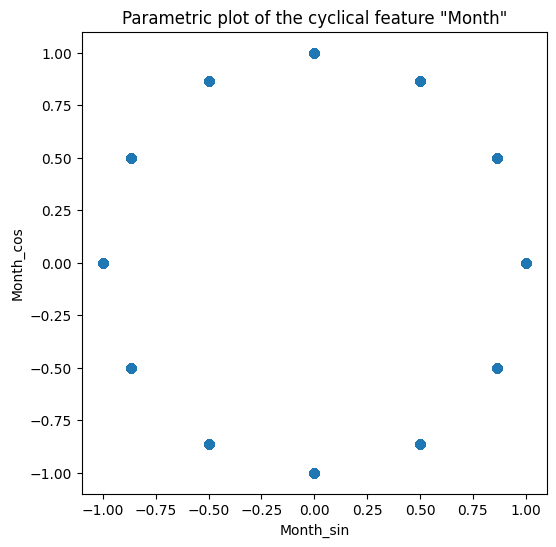

In [53]:
# 1.1 Encoding the cyclical feature "Month"

# (df.Month-1) because we want to start from 0, not 1
X_train['Month_sin'] = np.sin((X_train.Month-1)*(2.*np.pi/12))
X_train['Month_cos'] = np.cos((X_train.Month-1)*(2.*np.pi/12))

X_test['Month_sin'] = np.sin((X_test.Month-1)*(2.*np.pi/12))
X_test['Month_cos'] = np.cos((X_test.Month-1)*(2.*np.pi/12))

# Parametric plot of the cyclical feature "Month"
fig = plt.figure(figsize=(6, 6))
plt.scatter(X_train.Month_sin, X_train.Month_cos)
plt.xlabel('Month_sin')
plt.ylabel('Month_cos')
plt.title('Parametric plot of the cyclical feature "Month"')
plt.show()


In [54]:
# 1.2 Encoding the rest of the categorical features

# Encoding of the target variable. It will assign a number to each category.
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(le.classes_)
print(le.transform(le.classes_))

['construction' 'domestic' 'industrial' 'low income families'
 'rural commercial' 'rural domestic' 'rural expansion']
[0 1 2 3 4 5 6]


In [55]:
# Encoding of the categorical features

# encoder = ce.LeaveOneOutEncoder(cols=['Installation_zone', 'Consumer_number'])
# encoder = ce.CatBoostEncoder(cols=['Installation_zone', 'Consumer_number'])
encoder = ce.TargetEncoder(cols=['Installation_zone'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

print(X_train.head(), '\n')
print(X_test.head())

print("Installation zone nunique values: ", X_train.Installation_zone.nunique())
print("Installation zone unique values: ", X_train.Installation_zone.unique())


   Year  Month        Date  Installation_zone     Consumer_number  Consumption  Month_sin  Month_cos
0  2013      1  2013-01-01              1.051  MOGV36480546611521        0.000      0.000      1.000
2  2013      1  2013-01-01              1.244  QLLI18662653137621        1.000      0.000      1.000
3  2013      1  2013-01-01              1.244  HYUO61823402850645       13.000      0.000      1.000
4  2013      1  2013-01-01              1.244  CEHV63530382838218       12.000      0.000      1.000
5  2013      1  2013-01-01              1.051  LFTY10088860374163        7.000      0.000      1.000 

    Year  Month        Date  Installation_zone     Consumer_number  Consumption  Month_sin  Month_cos
1   2013      1  2013-01-01              1.244  VRFW65577141436242        6.000      0.000      1.000
13  2013      1  2013-01-01              1.160  JNXY97275145656574        6.000      0.000      1.000
16  2013      1  2013-01-01              1.244  XDON76058836220941        2.000      0

#### 2. Feature scaling

Necessary for some algorithms that are sensitive to the scale of the features or distance based, like SVM, KNN, Neural Netwworks, etc.

##### 2.1 Standardization

Standardization is a common method to scale the features. It transforms the data to have a mean of 0 and a standard deviation of 1. It is useful for features that follow a normal distribution. Afected by outliers. Computed as:

$x_{scaled} = \frac{x - \mu}{\sigma}$

##### 2.2 Min-max scaling (Normalization)

Min-max scaling transforms the data values to the range 0 - 1. Afected by outliers. It is calculated as: 

$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$


##### 2.3 Robust scaling

Similar to Standardization but instead of divide by $\sigma$ (standard deviation), it uses the interquartile range (IQR) to scale the data. It is useful for features that have outliers, because it is more robust to them.

$x_{scaled} = \frac{x - \mu}{Q_3 - Q_1}$

##### 2.4 Power transformation

Apply a power transformation to the data, in order to make it more Gaussian-like. Then standardize it.



In [56]:
scaler = RobustScaler()
# scaler = MinMaxScaler()
X_train['Consumption'] = scaler.fit_transform(np.array(X_train['Consumption']).reshape(-1, 1))
X_test['Consumption'] = scaler.transform(np.array(X_test['Consumption']).reshape(-1, 1))

print(X_train[:5], '\n')
print(X_test[:5])
print(X_train.describe())

   Year  Month        Date  Installation_zone     Consumer_number  Consumption  Month_sin  Month_cos
0  2013      1  2013-01-01              1.051  MOGV36480546611521       -1.853      0.000      1.000
2  2013      1  2013-01-01              1.244  QLLI18662653137621       -1.527      0.000      1.000
3  2013      1  2013-01-01              1.244  HYUO61823402850645        2.385      0.000      1.000
4  2013      1  2013-01-01              1.244  CEHV63530382838218        2.059      0.000      1.000
5  2013      1  2013-01-01              1.051  LFTY10088860374163        0.429      0.000      1.000 

    Year  Month        Date  Installation_zone     Consumer_number  Consumption  Month_sin  Month_cos
1   2013      1  2013-01-01              1.244  VRFW65577141436242        0.103      0.000      1.000
13  2013      1  2013-01-01              1.160  JNXY97275145656574        0.103      0.000      1.000
16  2013      1  2013-01-01              1.244  XDON76058836220941       -1.201      0

In [57]:
# Time series graph of consumption by consumer_type (scaled and without outliers)

data = pd.concat([X_train, X_test], axis=0)
data['Consumer_type'] = le.inverse_transform(pd.concat([pd.Series(y_train), pd.Series(y_test)], axis=0))

group = data.groupby(['Date','Consumer_type'])['Consumption'].mean().unstack()

fig = px.line(group, x=group.index, y=group.columns, title='Time series graph of consumption by consumer_type, scaled and without outliers')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Consumption [m3]',
)
fig.show()


### 3. Clustering and Subsampling

The idea is to reformat the data in a way that each row (sample) corresponds to a unique consumer, and each column corresponds to a unique combination of month and year (date). Then, we can apply clustering and dimensionality reduction techniques to the overrepresented classes, in order to reduce the dimensionality of the dataset and to find patterns in the data. This could be useful to find groups of consumers that have similar consumption patterns, so that we can reduce the dimensionality of the dataset but also mantain the information of the original features.

In [58]:
# The undersampling technique is only applied to the training set
# We add again the inverse encoded target variable to the training set
df_train = pd.DataFrame(X_train)
df_train['Consumer_type'] = le.inverse_transform(pd.Series(y_train))
df_train.head()

,Year,Month,Date,Installation_zone,Consumer_number,Consumption,Month_sin,Month_cos,Consumer_type
0,2013,1,2013-01-01,1.051,MOGV36480546611521,-1.853,0.000,1.000,domestic
2,2013,1,2013-01-01,1.244,QLLI18662653137621,-1.527,0.000,1.000,domestic
3,2013,1,2013-01-01,1.244,HYUO61823402850645,2.385,0.000,1.000,domestic
4,2013,1,2013-01-01,1.244,CEHV63530382838218,2.059,0.000,1.000,domestic
5,2013,1,2013-01-01,1.051,LFTY10088860374163,0.429,0.000,1.000,domestic


#### 3.1. Pivot table & NaN imputing

In [59]:
# Pivot the table for easier manipulation. Unique consumer_number per row, and the consumption of each month as a column
df_copy = df_train.copy()

df_pivot = df_copy.pivot_table(index='Consumer_number', columns=['Date'], values='Consumption')
df_pivot.head()
print(df_pivot.shape)

# The downside of this pivot is that it creates a lot of NaN values that had been previously dropped. Filling 
# them with 0 is not a good idea because it changes too much the distribution of the data, but its necessary to
# handle them in some way.
# df_pivot = df_pivot.fillna(0)

# Add the other interesting columns to the pivot table
df_pivot = df_pivot.merge((df_copy[['Consumer_number', 'Installation_zone', 'Consumer_type']]).drop_duplicates(subset='Consumer_number'), on='Consumer_number', how='left')

print(df_pivot.shape)
display(df_pivot.head())
df_pivot.Consumer_type.value_counts()

(20091, 84)
(20091, 87)


,Consumer_number,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,Installation_zone,Consumer_type
0,AABH19026729995402,-1.853,-0.485,-0.505,-0.463,-1.853,-1.853,-1.853,-0.395,-1.853,-0.455,-0.441,-0.427,-0.484,-0.496,-0.517,-0.475,-0.438,-0.430,-0.434,-1.853,-0.433,-1.853,-0.453,-1.853,-0.479,-0.492,-1.853,-0.470,-0.433,-0.425,-0.430,-0.402,-0.429,-0.462,-1.853,-0.434,-0.476,-0.489,-0.509,-0.467,-1.853,-0.422,-1.853,-0.399,-0.426,-0.459,-0.445,-0.431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.244,domestic
1,AABK96307399687530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115,0.102,-0.223,0.123,0.160,0.169,0.164,-0.223,0.165,0.132,0.146,0.429,0.301,0.288,0.429,0.310,0.347,0.355,0.350,0.378,0.429,0.429,0.755,0.346,0.429,0.429,0.403,0.445,0.482,0.490,0.486,1.081,0.755,0.454,0.755,1.081,1.051,domestic
2,AABP15829373762695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104,1.733,0.070,-0.549,0.149,0.158,0.153,0.180,0.154,0.121,-1.527,0.148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.051,domestic
3,AABU83206956615238,0.115,-0.223,-0.223,0.124,-0.549,0.169,0.164,0.191,0.165,0.132,0.755,-0.223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.262,-0.274,-1.527,-0.253,-1.201,-0.208,-0.875,-0.185,-0.211,-0.244,-0.231,-0.217,-1.201,-1.527,-1.201,-0.206,-0.169,-0.223,-1.201,-0.139,-0.165,-0.198,-0.184,-0.171,-0.284,-0.875,-1.527,-0.275,-0.238,-0.230,-0.234,-0.207,-0.233,-0.266,-1.201,-0.239,-0.324,-1.527,-0.357,-1.201,-0.278,-0.270,-0.275,-0.247,-0.273,-0.307,-0.293,-0.279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.160,domestic
4,AADB02534023128621,-1.527,-0.115,-0.136,-0.094,-0.057,-0.049,-0.549,-0.026,-1.853,-0.085,-0.549,0.755,-0.212,-1.853,-1.527,-0.875,0.103,-0.158,-0.163,-0.135,-0.162,-0.195,-0.181,-0.167,0.028,-0.549,-0.005,-0.223,0.074,0.082,0.077,-0.223,0.078,0.045,0.059,0.073,0.013,0.000,-0.875,0.022,0.059,0.067,0.062,0.103,0.063,0.030,0.044,0.058,0.103,-0.043,0.103,-0.021,0.015,0.024,0.019,-1.527,0.020,-0.013,0.001,0.014,-0.074,-0.875,-1.201,-0.065,-0.028,-0.549,-0.025,0.003,-0.024,-0.223,-0.223,-0.029,0.103,0.152,0.131,0.173,0.210,0.218,0.214,-0.223,0.215,0.182,0.196,0.209,1.244,domestic


Consumer_type
domestic               13161
rural domestic          4976
industrial              1319
rural commercial         333
construction             202
rural expansion           58
low income families       42
Name: count, dtype: int64

In [60]:
# Fill the NaN values with the weighted average between monthly mean of the consumer class
# that the consumer belongs to and the mean of the consumer

# The weights for the imputation
w1 = 0.5  # Group mean
w2 = 1 - w1  # Consumer mean

user_mean_consumption = df_pivot.iloc[:, 1:-2].mean(axis=1, skipna=True)
# Monthly mean consumption by consumer type (ignore the other columns)
group_mean_consumption = df_pivot[[col for col in df_pivot if col.startswith('20')] + ['Consumer_type']].groupby('Consumer_type').mean()

df_imputed = df_pivot.copy()

for index, row in df_imputed.iterrows():
    consumer_type = row['Consumer_type']
    for date_col in df_imputed.columns[1:-2]:  # Ignore Consumer_number, Installation_zone and Consumer_type
        if pd.isnull(row[date_col]):
            group_mean = group_mean_consumption.at[consumer_type, date_col]
            user_mean = user_mean_consumption[index]
            if pd.notnull(group_mean) or pd.notnull(user_mean):
                df_imputed.at[index, date_col] = (w1 * group_mean) + (w2 * user_mean) if pd.notnull(group_mean) else user_mean
            else:
                df_imputed.at[index, date_col] = 0

print(df_imputed.shape)
display(df_imputed.head())
df_imputed.Consumer_type.value_counts()


(20091, 87)


,Consumer_number,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,Installation_zone,Consumer_type
0,AABH19026729995402,-1.853,-0.485,-0.505,-0.463,-1.853,-1.853,-1.853,-0.395,-1.853,-0.455,-0.441,-0.427,-0.484,-0.496,-0.517,-0.475,-0.438,-0.430,-0.434,-1.853,-0.433,-1.853,-0.453,-1.853,-0.479,-0.492,-1.853,-0.470,-0.433,-0.425,-0.430,-0.402,-0.429,-0.462,-1.853,-0.434,-0.476,-0.489,-0.509,-0.467,-1.853,-0.422,-1.853,-0.399,-0.426,-0.459,-0.445,-0.431,-0.320,-0.325,-0.358,-0.302,-0.289,-0.288,-0.295,-0.276,-0.273,-0.297,-0.288,-0.283,-0.324,-0.321,-0.310,-0.314,-0.256,-0.270,-0.284,-0.242,-0.269,-0.289,-0.273,-0.280,-0.236,-0.261,-0.250,-0.225,-0.208,-0.194,-0.200,-0.187,-0.222,-0.224,-0.232,-0.206,1.244,domestic
1,AABK96307399687530,0.309,0.269,0.261,0.291,0.336,0.326,0.337,0.351,0.341,0.296,0.322,0.324,0.306,0.262,0.255,0.276,0.322,0.320,0.311,0.339,0.315,0.294,0.310,0.318,0.289,0.286,0.234,0.298,0.310,0.334,0.334,0.358,0.323,0.305,0.299,0.328,0.256,0.292,0.264,0.308,0.319,0.336,0.336,0.348,0.337,0.301,0.319,0.319,0.115,0.102,-0.223,0.123,0.160,0.169,0.164,-0.223,0.165,0.132,0.146,0.429,0.301,0.288,0.429,0.310,0.347,0.355,0.350,0.378,0.429,0.429,0.755,0.346,0.429,0.429,0.403,0.445,0.482,0.490,0.486,1.081,0.755,0.454,0.755,1.081,1.051,domestic
2,AABP15829373762695,0.162,0.122,0.114,0.144,0.189,0.179,0.190,0.204,0.194,0.149,0.176,0.177,0.159,0.115,0.108,0.129,0.175,0.173,0.164,0.192,0.168,0.147,0.163,0.171,0.142,0.139,0.087,0.151,0.163,0.187,0.187,0.211,0.176,0.158,0.152,0.181,0.104,1.733,0.070,-0.549,0.149,0.158,0.153,0.180,0.154,0.121,-1.527,0.148,0.119,0.114,0.081,0.137,0.150,0.150,0.143,0.163,0.165,0.142,0.151,0.156,0.115,0.118,0.129,0.125,0.182,0.169,0.155,0.197,0.169,0.150,0.165,0.159,0.202,0.178,0.189,0.214,0.231,0.245,0.239,0.252,0.217,0.214,0.207,0.233,1.051,domestic
3,AABU83206956615238,0.115,-0.223,-0.223,0.124,-0.549,0.169,0.164,0.191,0.165,0.132,0.755,-0.223,-0.071,-0.115,-0.122,-0.101,-0.055,-0.057,-0.066,-0.038,-0.061,-0.083,-0.067,-0.059,-0.262,-0.274,-1.527,-0.253,-1.201,-0.208,-0.875,-0.185,-0.211,-0.244,-0.231,-0.217,-1.201,-1.527,-1.201,-0.206,-0.169,-0.223,-1.201,-0.139,-0.165,-0.198,-0.184,-0.171,-0.284,-0.875,-1.527,-0.275,-0.238,-0.230,-0.234,-0.207,-0.233,-0.266,-1.201,-0.239,-0.324,-1.527,-0.357,-1.201,-0.278,-0.270,-0.275,-0.247,-0.273,-0.307,-0.293,-0.279,-0.028,-0.052,-0.041,-0.016,0.001,0.015,0.009,0.022,-0.013,-0.016,-0.023,0.003,1.160,domestic
4,AADB02534023128621,-1.527,-0.115,-0.136,-0.094,-0.057,-0.049,-0.549,-0.026,-1.853,-0.085,-0.549,0.755,-0.212,-1.853,-1.527,-0.875,0.103,-0.158,-0.163,-0.135,-0.162,-0.195,-0.181,-0.167,0.028,-0.549,-0.005,-0.223,0.074,0.082,0.077,-0.223,0.078,0.045,0.059,0.073,0.013,0.000,-0.875,0.022,0.059,0.067,0.062,0.103,0.063,0.030,0.044,0.058,0.103,-0.043,0.103,-0.021,0.015,0.024,0.019,-1.527,0.020,-0.013,0.001,0.014,-0.074,-0.875,-1.201,-0.065,-0.028,-0.549,-0.025,0.003,-0.024,-0.223,-0.223,-0.029,0.103,0.152,0.131,0.173,0.210,0.218,0.214,-0.223,0.215,0.182,0.196,0.209,1.244,domestic


Consumer_type
domestic               13161
rural domestic          4976
industrial              1319
rural commercial         333
construction             202
rural expansion           58
low income families       42
Name: count, dtype: int64

#### 3.2. Computing the best number of clusters

We use the custom class ``OptimalClusterFinder`` to find the best number of clusters for the KMeans algorithm. It uses the Elbow, Calinski-Harabasz and Davies-Bouldin methods to find the best number of clusters (the silhouette method is too slow). The idea is to find the best number of clusters for the KMeans algorithm, in order to group the consumers in a way that the intra-cluster distance is minimized and the inter-cluster distance is maximized. This will help us to find patterns in the data, and to reduce the dimensionality of the dataset.

In [61]:
to_subsample = ['domestic', 'rural domestic']
optimal_clusters = {}
for var in to_subsample:
    X_temp = df_imputed.loc[df_imputed['Consumer_type']==var,[v for v in df_imputed.columns.tolist() if v not in ['Consumer_number','Consumer_type']]].copy()

    finder = func.OptimalClusterFinder(max_clusters=30)
    optimal_clusters[var] = finder.fit(X_temp)
    optimal_clusters[var]['features'] = var
    print('Optimal number of clusters: ', optimal_clusters[var])

Finding the optimal number of clusters using the elbow method...


100%|██████████| 29/29 [00:05<00:00,  4.88it/s]


Finding the optimal number of clusters using the Calinski-Harabasz method...


100%|██████████| 28/28 [00:05<00:00,  4.91it/s]


Finding the optimal number of clusters using the Davies-Bouldin method...


100%|██████████| 28/28 [00:06<00:00,  4.66it/s]


Optimal number of clusters:  {'elbow': 2, 'calinski_harabasz': 2, 'davies_bouldin': 2, 'features': 'domestic'}
Finding the optimal number of clusters using the elbow method...


100%|██████████| 29/29 [00:02<00:00, 11.17it/s]


Finding the optimal number of clusters using the Calinski-Harabasz method...


100%|██████████| 28/28 [00:03<00:00,  8.61it/s]


Finding the optimal number of clusters using the Davies-Bouldin method...


100%|██████████| 28/28 [00:03<00:00,  8.87it/s]


Optimal number of clusters:  {'elbow': 2, 'calinski_harabasz': 2, 'davies_bouldin': 2, 'features': 'rural domestic'}


#### 3.3. Apply subsampling function

We use the custom function ``subsample_dataset`` to apply the subsampling technique to the overrepresented classes. The idea is to subsample by selecting representative samples of each cluster. In the hood, the function first applies PCA to reduce the dimensionality of the dataset, then applies KMeans to find the clusters, and finally selects the specified number of samples from each cluster.

In [62]:
df_copy = df_imputed.copy()
to_subsample = ['domestic'] # 'rural domestic'

print(df_copy.shape)
display(df_copy.head())
print(df_copy.Consumer_type.value_counts())

sample_size = {'domestic': 2000, 'rural domestic': 2000}
cluster_num = {'domestic': 2, 'rural domestic': 2}
subsampled_dfs = []

for type in to_subsample:
    # Filter by consumer type, and remove the consumer_type and consumer_number column.
    # Also remove the consumer_type==type samples from the original dataframe, as they will be added later
    # (only a reduced number of them, as they are the ones that will be sub-sampled).
    X_sub = df_copy.loc[df_copy['Consumer_type'] == type].copy()
    y_sub = X_sub.pop('Consumer_type')
    df_copy = df_copy.drop(df_copy[df_copy['Consumer_type'] == type].index)
    id_sub = X_sub.pop('Consumer_number')

    print(f"Subsampling {type} consumers...")

    # Apply the subsampling function
    X_subsampled, y_subsampled, subsampled_indices = func.subsample_dataset(X_sub, y_sub, cluster_count=cluster_num[type], sample_size=sample_size[type])

    # Add the consumer_number column back
    subsampled_dfs.append(pd.concat([X_subsampled, y_subsampled], axis=1))
    # subsampled_dfs[-1]['Consumer_number'] = id_sub[subsampled_indices]

# Concatenate the subsampled dataframes
df_train_subsampled = pd.concat(subsampled_dfs, ignore_index=True)

# Concatenate the original dataframe with the subsampled one
df_subsampled = pd.concat([df_copy, df_train_subsampled], ignore_index=True)

# Check the distribution of the consumer types
print(df_subsampled['Consumer_type'].value_counts())


(20091, 87)


,Consumer_number,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,Installation_zone,Consumer_type
0,AABH19026729995402,-1.853,-0.485,-0.505,-0.463,-1.853,-1.853,-1.853,-0.395,-1.853,-0.455,-0.441,-0.427,-0.484,-0.496,-0.517,-0.475,-0.438,-0.430,-0.434,-1.853,-0.433,-1.853,-0.453,-1.853,-0.479,-0.492,-1.853,-0.470,-0.433,-0.425,-0.430,-0.402,-0.429,-0.462,-1.853,-0.434,-0.476,-0.489,-0.509,-0.467,-1.853,-0.422,-1.853,-0.399,-0.426,-0.459,-0.445,-0.431,-0.320,-0.325,-0.358,-0.302,-0.289,-0.288,-0.295,-0.276,-0.273,-0.297,-0.288,-0.283,-0.324,-0.321,-0.310,-0.314,-0.256,-0.270,-0.284,-0.242,-0.269,-0.289,-0.273,-0.280,-0.236,-0.261,-0.250,-0.225,-0.208,-0.194,-0.200,-0.187,-0.222,-0.224,-0.232,-0.206,1.244,domestic
1,AABK96307399687530,0.309,0.269,0.261,0.291,0.336,0.326,0.337,0.351,0.341,0.296,0.322,0.324,0.306,0.262,0.255,0.276,0.322,0.320,0.311,0.339,0.315,0.294,0.310,0.318,0.289,0.286,0.234,0.298,0.310,0.334,0.334,0.358,0.323,0.305,0.299,0.328,0.256,0.292,0.264,0.308,0.319,0.336,0.336,0.348,0.337,0.301,0.319,0.319,0.115,0.102,-0.223,0.123,0.160,0.169,0.164,-0.223,0.165,0.132,0.146,0.429,0.301,0.288,0.429,0.310,0.347,0.355,0.350,0.378,0.429,0.429,0.755,0.346,0.429,0.429,0.403,0.445,0.482,0.490,0.486,1.081,0.755,0.454,0.755,1.081,1.051,domestic
2,AABP15829373762695,0.162,0.122,0.114,0.144,0.189,0.179,0.190,0.204,0.194,0.149,0.176,0.177,0.159,0.115,0.108,0.129,0.175,0.173,0.164,0.192,0.168,0.147,0.163,0.171,0.142,0.139,0.087,0.151,0.163,0.187,0.187,0.211,0.176,0.158,0.152,0.181,0.104,1.733,0.070,-0.549,0.149,0.158,0.153,0.180,0.154,0.121,-1.527,0.148,0.119,0.114,0.081,0.137,0.150,0.150,0.143,0.163,0.165,0.142,0.151,0.156,0.115,0.118,0.129,0.125,0.182,0.169,0.155,0.197,0.169,0.150,0.165,0.159,0.202,0.178,0.189,0.214,0.231,0.245,0.239,0.252,0.217,0.214,0.207,0.233,1.051,domestic
3,AABU83206956615238,0.115,-0.223,-0.223,0.124,-0.549,0.169,0.164,0.191,0.165,0.132,0.755,-0.223,-0.071,-0.115,-0.122,-0.101,-0.055,-0.057,-0.066,-0.038,-0.061,-0.083,-0.067,-0.059,-0.262,-0.274,-1.527,-0.253,-1.201,-0.208,-0.875,-0.185,-0.211,-0.244,-0.231,-0.217,-1.201,-1.527,-1.201,-0.206,-0.169,-0.223,-1.201,-0.139,-0.165,-0.198,-0.184,-0.171,-0.284,-0.875,-1.527,-0.275,-0.238,-0.230,-0.234,-0.207,-0.233,-0.266,-1.201,-0.239,-0.324,-1.527,-0.357,-1.201,-0.278,-0.270,-0.275,-0.247,-0.273,-0.307,-0.293,-0.279,-0.028,-0.052,-0.041,-0.016,0.001,0.015,0.009,0.022,-0.013,-0.016,-0.023,0.003,1.160,domestic
4,AADB02534023128621,-1.527,-0.115,-0.136,-0.094,-0.057,-0.049,-0.549,-0.026,-1.853,-0.085,-0.549,0.755,-0.212,-1.853,-1.527,-0.875,0.103,-0.158,-0.163,-0.135,-0.162,-0.195,-0.181,-0.167,0.028,-0.549,-0.005,-0.223,0.074,0.082,0.077,-0.223,0.078,0.045,0.059,0.073,0.013,0.000,-0.875,0.022,0.059,0.067,0.062,0.103,0.063,0.030,0.044,0.058,0.103,-0.043,0.103,-0.021,0.015,0.024,0.019,-1.527,0.020,-0.013,0.001,0.014,-0.074,-0.875,-1.201,-0.065,-0.028,-0.549,-0.025,0.003,-0.024,-0.223,-0.223,-0.029,0.103,0.152,0.131,0.173,0.210,0.218,0.214,-0.223,0.215,0.182,0.196,0.209,1.244,domestic


Consumer_type
domestic               13161
rural domestic          4976
industrial              1319
rural commercial         333
construction             202
rural expansion           58
low income families       42
Name: count, dtype: int64
Subsampling domestic consumers...
Consumer_type
rural domestic         4976
domestic               4000
industrial             1319
rural commercial        333
construction            202
rural expansion          58
low income families      42
Name: count, dtype: int64


In [63]:
df_subsampled.loc[df_subsampled['Consumer_type']=='domestic'].head()

,Consumer_number,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,Installation_zone,Consumer_type
6930,NaN,0.456,0.416,0.408,0.438,0.483,0.473,0.484,0.498,0.488,0.443,0.470,0.471,0.453,0.409,0.402,0.423,0.469,0.467,0.458,0.486,0.462,0.441,0.457,0.465,0.436,0.433,0.381,0.445,0.457,0.481,0.481,0.505,0.470,0.452,0.446,0.475,0.403,0.439,0.411,0.455,0.466,0.483,0.483,0.495,0.484,0.448,0.466,0.466,0.413,0.408,0.375,0.431,0.444,0.444,0.437,0.457,0.459,0.436,0.445,0.450,0.409,0.412,0.423,0.419,0.476,0.463,0.449,0.491,0.463,0.444,0.459,0.453,0.480,0.429,0.446,0.488,0.525,1.407,0.529,1.081,0.530,1.407,0.103,0.524,1.244,domestic
6931,NaN,1.733,1.407,0.799,0.841,0.878,0.886,3.037,0.909,0.882,0.849,0.863,0.877,0.766,1.733,0.733,0.775,0.812,0.820,2.059,0.843,0.816,0.783,0.797,0.811,2.059,2.059,1.733,0.779,0.816,0.825,0.820,0.847,0.821,0.788,1.733,0.815,0.774,0.761,0.740,0.782,0.819,0.828,0.823,0.850,0.824,0.791,3.689,0.103,0.659,0.654,0.621,0.677,0.690,0.690,0.683,0.703,0.706,0.682,0.691,0.696,1.034,2.059,1.001,1.043,1.080,1.088,1.084,3.363,1.085,2.711,1.065,1.079,0.742,0.718,0.729,0.754,0.771,0.785,0.779,0.792,0.757,0.754,0.747,0.773,1.051,domestic
6932,NaN,0.479,0.103,-0.223,0.488,0.525,0.533,0.528,0.556,2.059,2.059,0.510,0.523,-1.853,0.237,0.755,0.259,0.296,1.081,1.407,0.327,0.300,0.267,0.281,0.294,0.390,0.378,0.357,0.399,0.436,0.755,0.440,0.467,3.363,0.408,-0.549,-0.549,0.212,0.200,0.179,0.221,0.103,-0.223,0.262,0.289,0.263,0.755,0.243,0.257,0.984,0.971,0.951,0.993,1.030,1.038,1.033,2.711,1.034,3.363,1.015,1.733,0.513,0.755,0.480,0.429,0.559,0.567,0.755,2.385,1.407,0.530,0.544,0.557,-0.549,0.233,0.213,-0.875,0.292,0.103,0.295,2.059,0.296,0.263,0.277,0.291,1.160,domestic
6933,NaN,0.560,0.548,0.527,0.569,0.606,0.614,0.610,0.637,2.059,0.578,0.591,0.429,0.364,0.755,2.059,-0.223,0.410,0.429,0.429,0.441,0.414,0.381,0.395,0.409,0.323,0.319,0.267,0.331,0.343,0.368,0.367,0.391,0.357,0.338,0.332,0.361,0.258,0.245,0.103,0.266,0.303,0.429,0.103,0.334,0.308,0.275,0.288,0.755,0.477,0.464,0.444,1.081,0.523,0.531,0.526,0.554,1.081,0.494,0.508,0.522,0.138,0.125,-0.223,0.103,0.184,0.103,0.103,0.215,0.188,0.155,0.169,0.183,0.328,0.315,0.294,0.103,0.373,0.381,0.755,0.404,0.378,0.345,0.359,0.372,1.082,domestic
6934,NaN,0.309,0.269,0.261,0.291,0.336,0.326,0.337,0.351,0.341,0.296,0.322,0.324,0.168,2.059,0.135,0.177,0.214,0.222,0.218,0.245,-1.853,0.186,0.199,0.213,0.429,0.296,0.276,0.429,0.354,0.755,0.358,0.385,0.359,0.429,0.340,0.353,0.256,0.292,0.264,0.308,0.319,0.336,0.336,0.348,0.337,0.301,0.319,0.319,-1.853,-0.223,0.009,0.429,0.088,0.096,0.092,0.119,0.093,0.060,0.073,0.755,0.274,-0.875,0.241,1.407,0.319,0.755,0.323,0.350,0.324,0.291,0.305,0.318,0.762,1.407,0.729,0.771,2.059,0.816,0.812,0.839,0.813,0.780,0.793,0.807,1.160,domestic


In [64]:
# Asumiendo que df_pivot es tu DataFrame pivotado
df_melted = pd.melt(df_pivot, id_vars=['Consumer_number', 'Installation_zone', 'Consumer_type'], var_name='Date', value_name='Consumption')

# Convertir la columna 'Date' al formato de fecha si es necesario
df_melted['Date'] = pd.to_datetime(df_melted['Date'])

# Ahora df_melted está en formato largo, similar al DataFrame original antes del pivot

In [65]:
df_melted.shape

(1687644, 5)

In [66]:
# Apply the same operations to the test set (without imputing and undersampling)

df_test = pd.DataFrame(X_test)
df_test['Consumer_type'] = le.inverse_transform(pd.Series(y_test))
df_test.head()

# Pivot the table for easier manipulation. Unique consumer_number per row, and the consumption of each month as a column
df_copy_test = df_test.copy()

df_pivot_test = df_copy_test.pivot_table(index='Consumer_number', columns=['Date'], values='Consumption')
df_pivot_test.head()
print(df_pivot_test.shape)

# Add the other interesting columns to the pivot table
df_pivot_test = df_pivot_test.merge((df_copy_test[['Consumer_number', 'Installation_zone', 'Consumer_type']]).drop_duplicates(subset='Consumer_number'), on='Consumer_number', how='left')

print(df_pivot_test.shape)
display(df_pivot_test.head())
df_pivot_test.Consumer_type.value_counts()


# Fill the NaN values with the weighted average between monthly mean of the consumer class
# that the consumer belongs to and the mean of the consumer

# The weights for the imputation
w1 = 0.5  # Group mean
w2 = 1 - w1  # Consumer mean

user_mean_consumption = df_pivot_test.iloc[:, 1:-2].mean(axis=1, skipna=True)
# Monthly mean consumption by consumer type (ignore the other columns)
group_mean_consumption = df_pivot_test[[col for col in df_pivot_test if col.startswith('20')] + ['Consumer_type']].groupby('Consumer_type').mean()

df_imputed_test = df_pivot_test.copy()

for index, row in df_imputed_test.iterrows():
    consumer_type = row['Consumer_type']
    for date_col in df_imputed_test.columns[1:-2]:  # Ignore Consumer_number, Installation_zone and Consumer_type
        if pd.isnull(row[date_col]):
            group_mean = group_mean_consumption.at[consumer_type, date_col]
            user_mean = user_mean_consumption[index]
            if pd.notnull(group_mean) or pd.notnull(user_mean):
                df_imputed_test.at[index, date_col] = (w1 * group_mean) + (w2 * user_mean) if pd.notnull(group_mean) else user_mean
            else:
                df_imputed_test.at[index, date_col] = 0

print(df_imputed_test.shape)
display(df_imputed_test.head())
df_imputed_test.Consumer_type.value_counts()


(5023, 84)
(5023, 87)


,Consumer_number,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,Installation_zone,Consumer_type
0,AACM38974282265332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.223,0.103,0.186,0.755,0.265,0.429,0.269,0.296,0.270,0.237,0.250,0.264,0.273,1.081,0.240,-0.549,0.319,0.327,0.323,0.350,0.324,0.291,0.304,0.318,1.082,domestic
1,AAHK17622022002166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.059,0.373,0.352,0.394,0.431,0.440,0.429,0.462,0.436,0.403,0.417,-0.223,0.499,0.486,0.429,0.508,0.429,0.553,2.711,0.755,0.549,0.516,0.530,0.544,0.350,0.755,0.317,0.359,0.429,0.404,0.755,0.427,0.755,0.429,0.381,0.395,0.287,0.103,0.254,1.081,0.332,0.341,0.429,0.363,0.337,0.429,0.318,0.331,0.219,0.429,0.103,0.228,0.265,0.273,0.269,0.296,0.270,0.237,0.250,0.264,0.328,0.315,0.294,0.336,0.103,0.381,0.377,0.404,0.378,0.755,0.359,0.372,1.160,domestic
2,AAHK62978571959855,-0.891,-1.853,-0.953,-1.853,-0.861,-0.798,-0.742,-0.580,-0.659,-1.853,-0.894,-0.921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.965,rural domestic
3,AAIZ67944867754614,-0.223,-0.243,-0.247,-0.171,-0.155,-0.092,-0.035,0.755,0.048,-0.127,-0.187,-0.215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.584,-0.642,-0.646,-0.549,-0.554,-0.491,-0.434,-0.273,-0.351,-0.526,-0.875,-0.614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.965,rural domestic
4,AAJX02954672369919,0.832,0.819,0.799,0.841,0.878,2.059,0.881,2.059,0.882,0.849,0.863,0.877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.051,domestic


(5023, 87)


,Consumer_number,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,Installation_zone,Consumer_type
0,AACM38974282265332,0.270,0.208,0.213,0.242,0.280,0.283,0.282,0.311,0.296,0.236,0.274,0.284,0.247,0.204,0.184,0.221,0.249,0.272,0.249,0.273,0.282,0.248,0.239,0.260,0.226,0.225,0.178,0.228,0.251,0.284,0.301,0.298,0.266,0.239,0.242,0.281,0.206,0.253,0.219,0.251,0.266,0.292,0.286,0.310,0.289,0.255,0.250,0.261,0.211,0.222,0.202,0.219,0.248,0.250,0.247,0.260,0.255,0.227,0.246,0.249,-0.223,0.103,0.186,0.755,0.265,0.429,0.269,0.296,0.270,0.237,0.250,0.264,0.273,1.081,0.240,-0.549,0.319,0.327,0.323,0.350,0.324,0.291,0.304,0.318,1.082,domestic
1,AAHK17622022002166,0.356,0.293,0.298,0.327,0.365,0.368,0.367,0.396,0.381,0.321,0.359,0.369,2.059,0.373,0.352,0.394,0.431,0.440,0.429,0.462,0.436,0.403,0.417,-0.223,0.499,0.486,0.429,0.508,0.429,0.553,2.711,0.755,0.549,0.516,0.530,0.544,0.350,0.755,0.317,0.359,0.429,0.404,0.755,0.427,0.755,0.429,0.381,0.395,0.287,0.103,0.254,1.081,0.332,0.341,0.429,0.363,0.337,0.429,0.318,0.331,0.219,0.429,0.103,0.228,0.265,0.273,0.269,0.296,0.270,0.237,0.250,0.264,0.328,0.315,0.294,0.336,0.103,0.381,0.377,0.404,0.378,0.755,0.359,0.372,1.160,domestic
2,AAHK62978571959855,-0.891,-1.853,-0.953,-1.853,-0.861,-0.798,-0.742,-0.580,-0.659,-1.853,-0.894,-0.921,-0.742,-0.768,-0.779,-0.713,-0.661,-0.660,-0.624,-0.518,-0.579,-0.691,-0.726,-0.744,-0.747,-0.797,-0.794,-0.741,-0.759,-0.714,-0.632,-0.543,-0.579,-0.700,-0.744,-0.775,-0.723,-0.772,-0.774,-0.709,-0.702,-0.651,-0.611,-0.495,-0.579,-0.666,-0.740,-0.751,-0.775,-0.829,-0.846,-0.792,-0.770,-0.755,-0.719,-0.598,-0.609,-0.746,-0.794,-0.815,-0.788,-0.815,-0.812,-0.766,-0.768,-0.709,-0.679,-0.573,-0.585,-0.743,-0.788,-0.837,-0.757,-0.798,-0.791,-0.775,-0.743,-0.705,-0.675,-0.563,-0.622,-0.771,-0.778,-0.832,4.965,rural domestic
3,AAIZ67944867754614,-0.223,-0.243,-0.247,-0.171,-0.155,-0.092,-0.035,0.755,0.048,-0.127,-0.187,-0.215,-0.361,-0.387,-0.398,-0.332,-0.280,-0.279,-0.243,-0.137,-0.198,-0.310,-0.345,-0.364,-0.366,-0.416,-0.414,-0.360,-0.378,-0.333,-0.251,-0.162,-0.198,-0.319,-0.363,-0.394,-0.342,-0.391,-0.393,-0.328,-0.322,-0.270,-0.230,-0.115,-0.199,-0.285,-0.359,-0.370,-0.584,-0.642,-0.646,-0.549,-0.554,-0.491,-0.434,-0.273,-0.351,-0.526,-0.875,-0.614,-0.407,-0.434,-0.431,-0.385,-0.387,-0.328,-0.298,-0.193,-0.204,-0.362,-0.407,-0.456,-0.376,-0.417,-0.410,-0.394,-0.362,-0.324,-0.294,-0.183,-0.241,-0.390,-0.397,-0.451,4.965,rural domestic
4,AAJX02954672369919,0.832,0.819,0.799,0.841,0.878,2.059,0.881,2.059,0.882,0.849,0.863,0.877,0.634,0.591,0.571,0.608,0.636,0.659,0.636,0.660,0.669,0.635,0.626,0.647,0.613,0.612,0.565,0.615,0.638,0.671,0.688,0.685,0.653,0.626,0.629,0.668,0.593,0.640,0.606,0.638,0.653,0.679,0.673,0.697,0.676,0.642,0.637,0.648,0.598,0.609,0.589,0.606,0.635,0.637,0.634,0.647,0.642,0.614,0.633,0.636,0.599,0.618,0.627,0.615,0.667,0.668,0.665,0.685,0.658,0.639,0.663,0.634,0.684,0.672,0.671,0.702,0.699,0.736,0.717,0.731,0.679,0.698,0.687,0.717,1.051,domestic


Consumer_type
domestic               3290
rural domestic         1244
industrial              330
rural commercial         84
construction             50
rural expansion          15
low income families      10
Name: count, dtype: int64

### 4. Oversampling

The following graph shows the temporal consumption for the less represented Consumer_types (low income families, construction, rural expansion and rural commercial). It displays the average group consumption with a shaded area that represents the interquartile range (25-75 %), in order to diminish the effect of outliers. It shows that in theory, is possible to do oversampling for these groups, by sampling from its distribution.

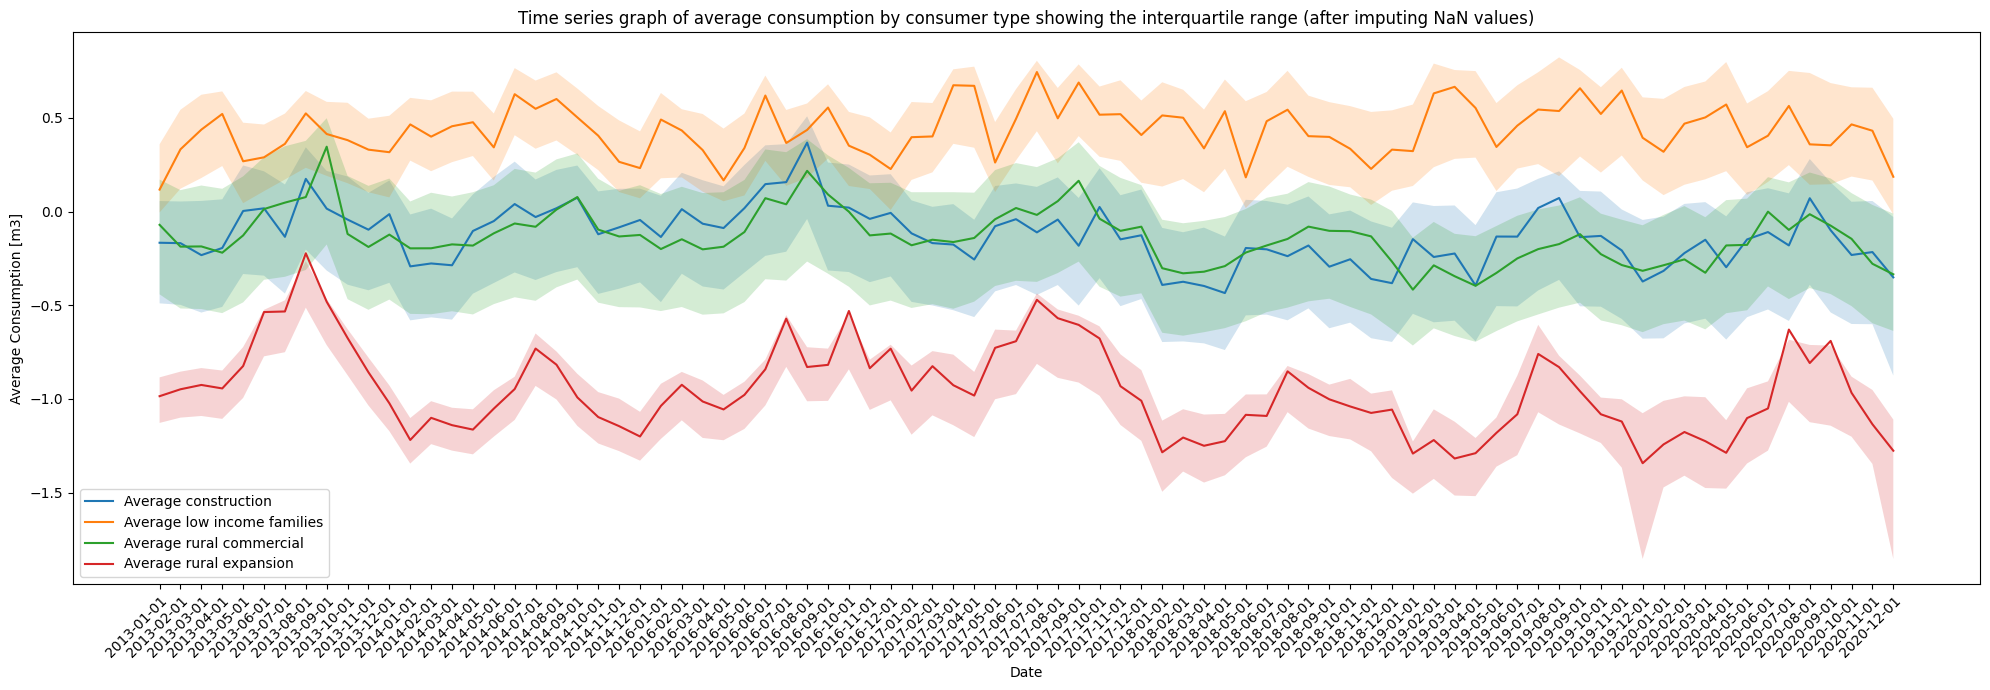

In [67]:
# Time series graph of average consumption by consumer type showing the interquartile range

grouped = df_imputed.loc[df_imputed['Consumer_type'].isin(['low income families', 'construction', 'rural expansion', 'rural commercial'])].groupby('Consumer_type')


fig, ax = plt.subplots(figsize=(20, 7))

for name, group in grouped:
    
    dates = group.columns[1:-2]
    avg = group[dates].mean()
    std_dev = group[dates].std()
    percent25 = group[dates].quantile(0.25)
    percent75 = group[dates].quantile(0.75)

    ax.plot(dates, avg, label=f'Average {name}')

    # Add the shaded region for the standard deviation
    # ax.fill_between(dates, avg - std_dev, avg + std_dev, alpha=0.2)
    # Add the shaded region for the interquartile range
    ax.fill_between(dates, percent25, percent75, alpha=0.2)

ax.set_title('Time series graph of average consumption by consumer type showing the interquartile range (after imputing NaN values)')
ax.set_xlabel('Date')
ax.set_ylabel('Average Consumption [m3]')
ax.legend()
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

In [68]:
to_oversample = ['low income families', 'construction', 'rural expansion', 'rural commercial']
df_oversampled = df_subsampled.copy()
synthetic_dfs = []

for minority_class in to_oversample:
    current_count = df_oversampled[df_oversampled['Consumer_type'] == minority_class].shape[0]
    n_samples = 4000 - current_count  # Asegúrate de que desired_count es el conteo deseado después del oversampling.
    
    if n_samples > 0:
        df_synthetic = func.generate_synthetic_samples(df_oversampled, minority_class, n_samples)
        synthetic_dfs.append(df_synthetic)

df_oversampled = pd.concat([df_oversampled] + synthetic_dfs, ignore_index=True)

print(df_oversampled['Consumer_type'].value_counts())

Consumer_type
rural domestic         4976
construction           4000
rural commercial       4000
low income families    4000
rural expansion        4000
domestic               4000
industrial             1319
Name: count, dtype: int64


In [69]:
print(df_oversampled.shape)
display(df_oversampled.head())
print(df_oversampled.Consumer_type.value_counts())

(26295, 87)


,Consumer_number,2013-01-01,2013-02-01,2013-03-01,2013-04-01,2013-05-01,2013-06-01,2013-07-01,2013-08-01,2013-09-01,2013-10-01,2013-11-01,2013-12-01,2014-01-01,2014-02-01,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,Installation_zone,Consumer_type
0,AAFB08665155868896,0.118,0.079,0.066,0.120,0.127,0.172,0.224,0.337,0.289,0.167,0.084,0.107,0.081,0.041,0.047,0.095,0.134,0.156,0.177,0.313,0.258,0.118,0.091,0.064,0.109,0.065,0.054,0.098,0.099,0.144,0.213,0.315,0.251,0.130,0.107,0.076,-0.217,-0.276,-0.279,-0.203,-0.187,-0.124,0.103,0.429,0.015,-0.159,-0.220,-0.247,0.847,0.789,0.785,0.861,-1.201,0.940,0.996,1.158,0.206,0.905,6.623,5.319,0.058,0.021,0.017,0.070,0.079,0.130,0.170,0.264,0.216,0.083,0.057,0.014,-0.875,-0.067,-0.071,0.005,0.021,2.059,0.141,3.689,0.224,0.755,-0.011,-0.875,4.964,rural domestic
1,AAJB06403857669117,-0.701,-0.741,-0.753,-0.700,-0.693,-0.647,-0.595,-0.482,-0.531,-0.652,-0.736,-0.713,-0.739,-0.779,-0.773,-0.725,-0.685,-0.663,-0.643,-0.506,-0.562,-0.702,-0.728,-0.756,-0.916,-0.974,-0.978,-0.902,-1.853,-1.853,-0.766,-0.604,-0.683,-0.858,-0.918,-0.946,-0.744,-0.781,-0.779,-0.717,-0.718,-0.661,-0.648,-0.533,-0.589,-0.702,-0.754,-0.773,-0.772,-0.803,-0.810,-0.764,-0.746,-0.727,-0.694,-0.573,-0.614,-0.725,-0.763,-0.819,-0.761,-0.799,-0.802,-0.749,-0.740,-0.690,-0.650,-0.556,-0.604,-0.737,-0.763,-0.806,-0.751,-0.779,-0.781,-0.737,-0.740,-0.685,-0.644,-0.544,-0.606,-0.707,-0.748,-0.812,4.976,rural domestic
2,AAJS70093165963865,0.513,0.550,0.527,2.385,2.385,0.555,0.596,0.575,0.566,0.591,0.602,0.553,0.390,1.407,0.405,0.411,0.417,0.432,0.473,0.452,0.444,0.468,2.711,0.430,0.773,0.810,0.787,0.793,0.800,4.667,0.856,2.711,0.826,0.851,2.385,0.813,3.037,2.385,0.621,0.627,0.633,0.648,0.689,0.668,0.660,0.684,0.695,0.646,3.037,0.712,1.407,4.341,0.701,0.717,2.711,0.737,0.728,0.753,2.711,0.715,3.689,0.794,0.771,3.689,0.783,0.798,2.059,0.818,0.809,0.834,0.845,0.796,3.363,1.733,0.289,2.059,0.301,0.103,1.407,0.336,0.328,2.059,0.363,0.314,1.082,industrial
3,AAKH04447090652763,-0.046,-0.085,-0.098,-0.044,-0.037,0.008,0.060,0.173,0.124,0.003,-0.081,-0.057,-0.083,-0.123,-0.117,-0.069,-0.030,-0.008,0.013,0.149,0.093,-0.046,-0.073,-0.101,-0.056,-0.100,-0.111,-0.067,-0.065,-0.020,0.049,0.151,0.086,-0.034,-0.057,-0.088,-0.088,-0.125,-0.123,-0.062,-0.063,-0.005,0.008,0.123,0.066,-0.046,-0.098,-0.117,-0.117,-0.148,-0.155,-0.109,-0.091,-0.072,-0.039,0.083,0.041,-0.069,-0.107,-0.164,-0.106,-0.143,-0.147,-0.094,-0.085,-0.034,0.005,0.100,0.052,-0.082,-0.108,-0.150,-0.047,-0.105,1.407,-0.033,-0.017,0.046,0.103,0.264,-0.875,1.407,1.407,-0.077,5.009,rural domestic
4,AALZ29356677789831,-0.722,-0.761,-0.774,-0.720,-0.713,-0.667,-0.616,-0.503,-0.551,-0.672,-0.756,-0.733,-0.759,-0.799,-0.793,-0.745,-0.706,-0.684,-0.663,-0.526,-0.582,-0.722,-0.748,-0.776,-0.731,-0.775,-0.786,-0.742,-0.741,-0.696,-0.626,-0.525,-0.589,-0.710,-0.732,-0.763,-0.764,-0.801,-0.799,-0.737,-0.739,-0.681,-0.668,-0.553,-0.609,-0.722,-0.774,-0.793,-0.964,-1.023,-1.026,-0.950,-0.934,-0.871,-1.853,-0.653,-0.732,-0.906,-0.967,-1.853,-0.781,-0.819,-0.822,-0.769,-0.760,-0.710,-0.670,-0.576,-0.624,-0.757,-0.783,-0.826,-0.771,-0.799,-0.801,-0.757,-0.760,-0.705,-0.664,-0.564,-0.626,-0.727,-0.768,-0.833,5.004,rural domestic


Consumer_type
rural domestic         4976
construction           4000
rural commercial       4000
low income families    4000
rural expansion        4000
domestic               4000
industrial             1319
Name: count, dtype: int64


In [70]:

def plot_time_series_with_stats(df_original, df_expanded, minority_class):
    df_filtered = df_original[df_original['Consumer_type'] == minority_class]

    df_filtered = df_filtered.drop(columns=['Consumer_number', 'Consumer_type'])
    mean_series = df_filtered[[col for col in df_filtered if col.startswith('20')]].mean()
    std_series = df_filtered[[col for col in df_filtered if col.startswith('20')]].std()

    plt.figure(figsize=(20, 7))
    # time_points = range(len(mean_series))
    time_points = df_filtered.columns[:-1]

    # Plot the mean and standard deviation
    plt.plot(time_points, mean_series, label='Average', color='blue')
    plt.fill_between(time_points, mean_series-std_series, mean_series+std_series, color='blue', alpha=0.2)

    # Plot some of the synthetic samples
    for _, row in df_expanded.loc[(df_expanded['Consumer_type']==minority_class) & (df_expanded['Consumer_number']=='synthetic')].sample(n=10).iterrows():  
        plt.plot(time_points, row[1:-2], linestyle='--', alpha=0.7) 

    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.title(f'Synthetic time series for {minority_class}')
    plt.xlabel('Time')
    plt.ylabel('Comsumption [m3]')
    plt.legend()

    plt.tight_layout()
    plt.show()


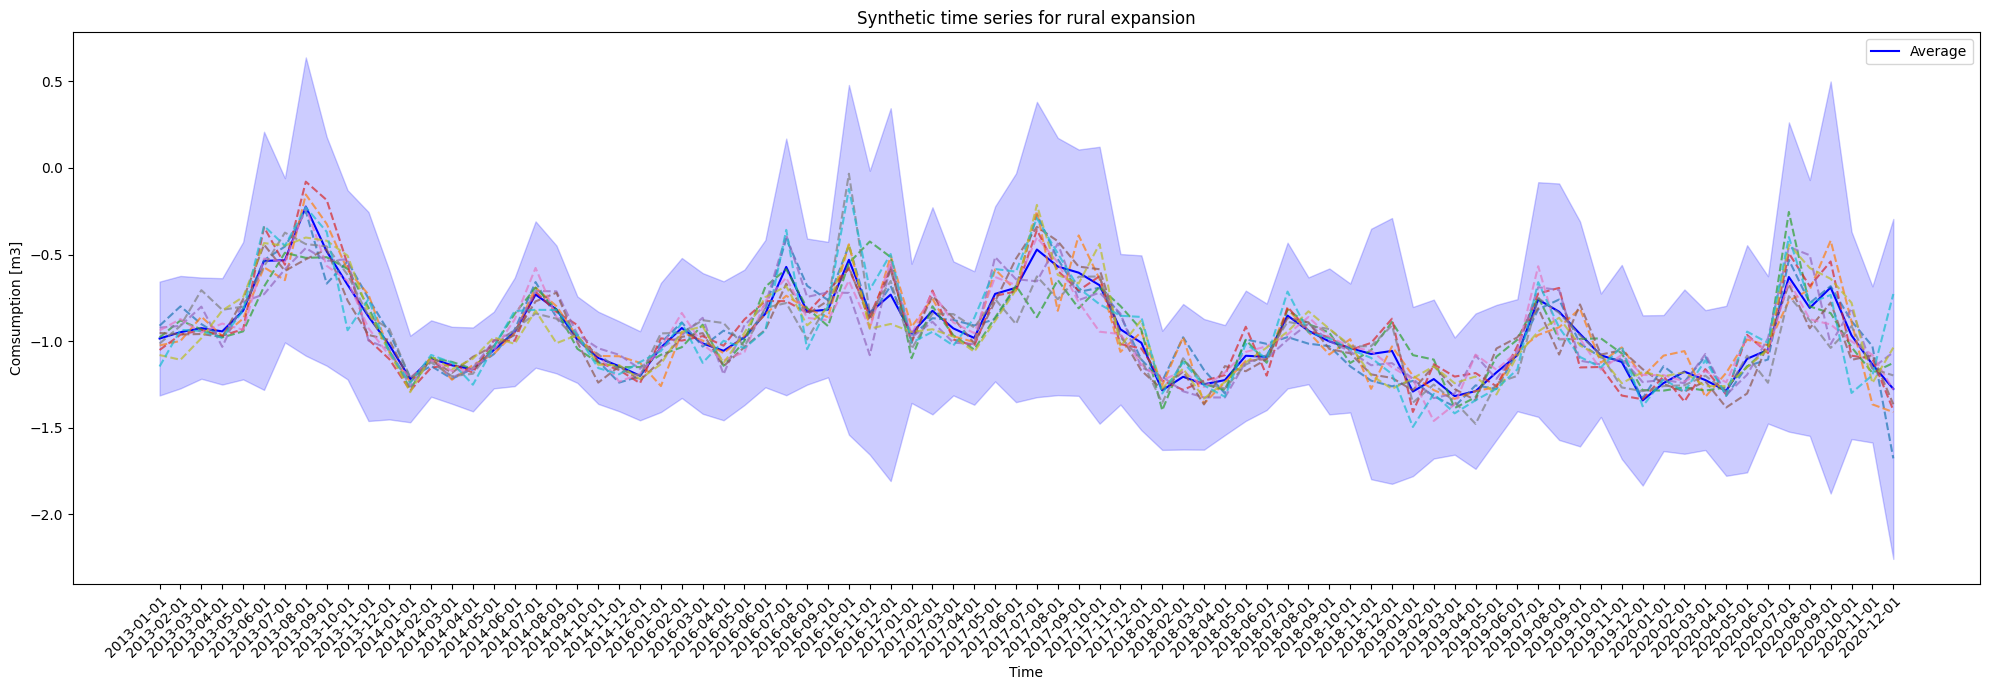

In [71]:
plot_time_series_with_stats(df_subsampled, df_oversampled, 'rural expansion')

In [72]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(865099, 8)
(216794, 8)
(865099,)
(216794,)


#### Testing with LSTM

accuracy,▁▇█████
epoch,▁▂▃▅▆▇█
loss,█▃▂▁▁▁▁
precision_1,▁▆▇████
recall_1,▁▇█████
val_accuracy,▁▄▅▇▇██
val_loss,█▄▄▁▁▁▁
val_precision_1,▁▄▅█▇██
val_recall_1,▁▄▅▇▇█▇
accuracy,0.94303
best_epoch,5


Epoch 1/10
821/822 [============================>.] - ETA: 0s - loss: 0.8430 - precision_2: 0.8001 - recall_2: 0.6036 - accuracy: 0.6999

/home/codespace/.python/current/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best)... Done. 0.0s


822/822 [==============================] - 68s 80ms/step - loss: 0.8425 - precision_2: 0.8003 - recall_2: 0.6039 - accuracy: 0.7002 - val_loss: 0.9269 - val_precision_2: 0.7802 - val_recall_2: 0.6411 - val_accuracy: 0.7131
Epoch 2/10
821/822 [============================>.] - ETA: 0s - loss: 0.3410 - precision_2: 0.9221 - recall_2: 0.8908 - accuracy: 0.9060

/home/codespace/.python/current/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best)... Done. 0.0s


822/822 [==============================] - 34s 42ms/step - loss: 0.3409 - precision_2: 0.9221 - recall_2: 0.8908 - accuracy: 0.9060 - val_loss: 0.4806 - val_precision_2: 0.8810 - val_recall_2: 0.8563 - val_accuracy: 0.8720
Epoch 3/10
822/822 [==============================] - 30s 37ms/step - loss: 0.2618 - precision_2: 0.9311 - recall_2: 0.9142 - accuracy: 0.9220 - val_loss: 0.5007 - val_precision_2: 0.8433 - val_recall_2: 0.7812 - val_accuracy: 0.8147
Epoch 4/10
821/822 [============================>.] - ETA: 0s - loss: 0.2384 - precision_2: 0.9360 - recall_2: 0.9216 - accuracy: 0.9285

/home/codespace/.python/current/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best)... Done. 0.0s


822/822 [==============================] - 36s 44ms/step - loss: 0.2383 - precision_2: 0.9361 - recall_2: 0.9217 - accuracy: 0.9285 - val_loss: 0.3958 - val_precision_2: 0.9186 - val_recall_2: 0.8790 - val_accuracy: 0.9021
Epoch 5/10
822/822 [==============================] - 30s 37ms/step - loss: 0.2108 - precision_2: 0.9423 - recall_2: 0.9325 - accuracy: 0.9370 - val_loss: 0.4024 - val_precision_2: 0.9155 - val_recall_2: 0.8957 - val_accuracy: 0.9088
Epoch 6/10
822/822 [==============================] - ETA: 0s - loss: 0.2021 - precision_2: 0.9447 - recall_2: 0.9345 - accuracy: 0.9389

/home/codespace/.python/current/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best)... Done. 0.0s


822/822 [==============================] - 35s 43ms/step - loss: 0.2021 - precision_2: 0.9447 - recall_2: 0.9345 - accuracy: 0.9389 - val_loss: 0.3676 - val_precision_2: 0.9222 - val_recall_2: 0.8804 - val_accuracy: 0.9017
Epoch 7/10
821/822 [============================>.] - ETA: 0s - loss: 0.1873 - precision_2: 0.9497 - recall_2: 0.9375 - accuracy: 0.9426

/home/codespace/.python/current/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best)... Done. 0.0s


822/822 [==============================] - 34s 42ms/step - loss: 0.1873 - precision_2: 0.9497 - recall_2: 0.9375 - accuracy: 0.9427 - val_loss: 0.3163 - val_precision_2: 0.9351 - val_recall_2: 0.9034 - val_accuracy: 0.9184
Epoch 8/10
822/822 [==============================] - 30s 37ms/step - loss: 0.1752 - precision_2: 0.9534 - recall_2: 0.9383 - accuracy: 0.9455 - val_loss: 0.3289 - val_precision_2: 0.9339 - val_recall_2: 0.9005 - val_accuracy: 0.9220
Epoch 9/10
821/822 [============================>.] - ETA: 0s - loss: 0.1798 - precision_2: 0.9523 - recall_2: 0.9376 - accuracy: 0.9441

/home/codespace/.python/current/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best)... Done. 0.0s


822/822 [==============================] - 35s 42ms/step - loss: 0.1798 - precision_2: 0.9523 - recall_2: 0.9376 - accuracy: 0.9441 - val_loss: 0.3158 - val_precision_2: 0.9387 - val_recall_2: 0.8927 - val_accuracy: 0.9188
Epoch 10/10
821/822 [============================>.] - ETA: 0s - loss: 0.1635 - precision_2: 0.9571 - recall_2: 0.9429 - accuracy: 0.9495

/home/codespace/.python/current/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets


INFO:tensorflow:Assets written to: /workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best/assets
wandb: Adding directory to artifact (/workspaces/ML4DS/wandb/run-20240207_132916-3uvng3rs/files/model-best)... Done. 0.0s


822/822 [==============================] - 34s 42ms/step - loss: 0.1634 - precision_2: 0.9571 - recall_2: 0.9429 - accuracy: 0.9496 - val_loss: 0.2981 - val_precision_2: 0.9372 - val_recall_2: 0.9128 - val_accuracy: 0.9263


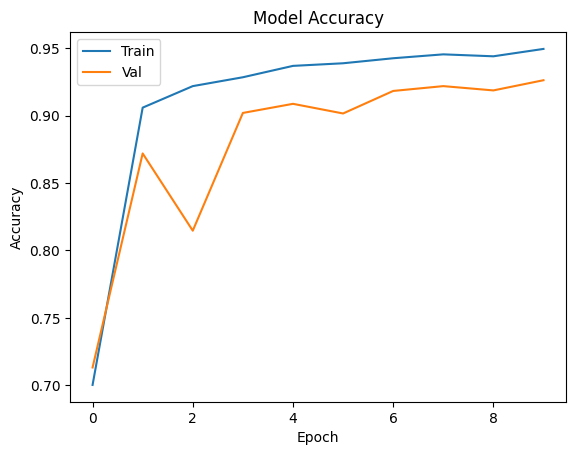

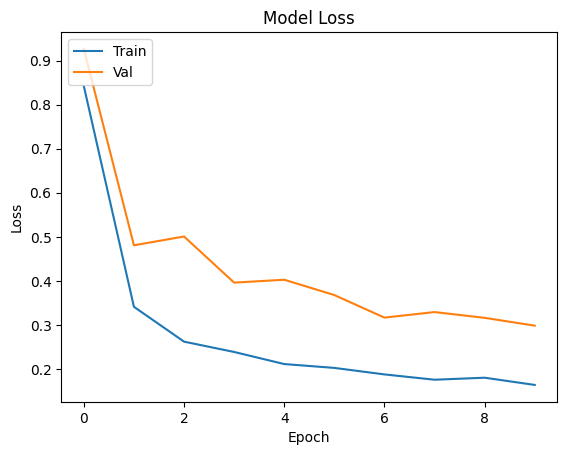

157/157 [==============================] - 2s 11ms/step - loss: 0.2981 - precision_2: 0.9372 - recall_2: 0.9128 - accuracy: 0.9263


ValueError: too many values to unpack (expected 2)

In [73]:
train = df_oversampled.drop(columns=['Consumer_type', 'Consumer_number'])
test = df_imputed_test.drop(columns=['Consumer_type', 'Consumer_number'])

# Dividir los datos en características y etiquetas
X_train = np.reshape(train, (train.shape[0], train.shape[1], 1))
y_train = to_categorical(le.fit_transform(df_oversampled['Consumer_type']))
# y_train = le.fit_transform(df_oversampled['Consumer_type'])

X_test = np.reshape(test, (test.shape[0], test.shape[1], 1))
y_test = to_categorical(le.transform(df_imputed_test['Consumer_type']))
# y_test = le.transform(df_imputed_test['Consumer_type'])

# Número de características y número de clases
n_features = X_train.shape[2]
n_classes = y_train.shape[1]


# 1. Iniciar una sesión de W&B
wandb.init(project='ML4DS', notes="time series format + imputing train and test + undersampling domestic + oversampling all + LSTM", save_code=True)

# 2. Configurar los hiperparámetros (esto es solo un ejemplo)
config = wandb.config
config.learning_rate = 0.001
config.epochs = 10
config.batch_size = 32
config.n_features = X_train.shape[2]
config.n_classes = y_train.shape[1]

# Construir la Red LSTM para clasificación
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], config.n_features)))
model.add(LSTM(units=50))
model.add(Dense(units=config.n_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision(), Recall(), 'accuracy'])

# 3. Entrenar la red con el callback de W&B
history = model.fit(
    X_train, y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_data=(X_test, y_test),
    callbacks=[WandbCallback()]
)

# 4. Agregar visualizaciones de entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Evaluar la red
eval_results = model.evaluate(X_test, y_test)


# Hacer predicciones
y_pred = model.predict(X_test)
predicted_classes = np.argmax(y_pred, axis=1)

# Convertir las predicciones de vuelta a etiquetas nominales
predicted_labels = le.inverse_transform(predicted_classes)


# Imprimir los resultados de la evaluación
print(f'Loss: {eval_results[0]}')
print(f'Accuracy: {eval_results[1]}')
print(f'Precision: {eval_results[2]}')
print(f'Recall: {eval_results[3]}')

# Ahora, si quieres registrar la precisión y el recall en W&B, puedes hacerlo así:
wandb.log({'Final Loss': eval_results[0], 'Final Accuracy': eval_results[1], 'Final Precision': eval_results[2], 'Final Recall': eval_results[3]})
# Terminar la sesión de W&B
wandb.finish()

In [30]:
# Asumiendo que y_test es one-hot encoded y y_pred son las predicciones del modelo
y_true = np.argmax(y_test, axis=1)  # Convertir de one-hot a etiquetas
y_pred = np.argmax(model.predict(X_test), axis=1)  # Obtener la clase con la mayor probabilidad

# Calcular la matriz de confusión
matrix = confusion_matrix(y_true, y_pred)

# Suponiendo que 'le' es tu LabelEncoder y has codificado las clases de 'Consumer_type'
class_names = le.classes_

# Usar la función para plotear la matriz de confusión
fig = func.plot_confusion_matrix(matrix, class_names)


AxisError: axis 1 is out of bounds for array of dimension 1

### 5. Training & Validation

(26295, 38)
(5023, 38)
RandomForestClassifier


wandb: Currently logged in as: rchavezt (rchavezt-team). Use `wandb login --relogin` to force relogin


Train score: 0.9989731888191672
Test score: 0.9440573362532351
Accuracy score: 0.9440573362532351
Precision score: 0.5229497672893609
Recall score: 0.4071941080287526
F1 score: 0.4285239939053448


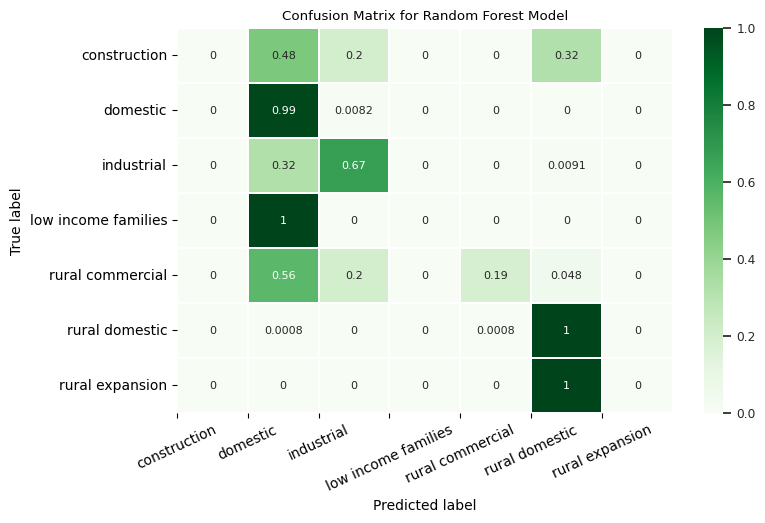

/home/codespace/.python/current/lib/python3.11/site-packages/plotly/matplotlylib/renderer.py:645: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.

/home/codespace/.python/current/lib/python3.11/site-packages/plotly/matplotlylib/renderer.py:571: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/home/codespace/.python/current/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/h

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.95      0.99      0.97      3290
           2       0.80      0.67      0.73       330
           3       0.00      0.00      0.00        10
           4       0.94      0.19      0.32        84
           5       0.97      1.00      0.98      1244
           6       0.00      0.00      0.00        15

    accuracy                           0.94      5023
   macro avg       0.52      0.41      0.43      5023
weighted avg       0.93      0.94      0.93      5023




/home/codespace/.python/current/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



F1 (macro avg),▁
Precision (macro avg),▁
Recall (macro avg),▁
F1 (macro avg),0.42852
Precision (macro avg),0.52295
Recall (macro avg),0.40719


In [25]:
# Train and validate some scikit-learn models

X_train = df_oversampled.drop(columns=['Consumer_type', 'Consumer_number'])
y_train = le.fit_transform(df_oversampled['Consumer_type'])
features = X_train.columns.tolist()

X_test = df_imputed_test.drop(columns=['Consumer_type', 'Consumer_number'])
y_test = le.transform(df_imputed_test['Consumer_type'])

# Apply pca to the training set, excluding the column 'Installation_zone'
pca = PCA(n_components=0.9, random_state=123)
zone = X_train.pop('Installation_zone')
X_train = pca.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train['Installation_zone'] = zone
X_train.columns = [f'PC{i+1}' for i in range(X_train.shape[1])]

# Apply pca to the test set, excluding the column 'Installation_zone'
zone = X_test.pop('Installation_zone')
X_test = pca.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test['Installation_zone'] = zone
X_test.columns = [f'PC{i+1}' for i in range(X_test.shape[1])]


print(X_train.shape)
print(X_test.shape)

# Grid search for Random Forest Classifier
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


models = {
    "RandomForestClassifier": RandomForestClassifier(random_state=123, n_jobs=-1, max_depth= 20, min_samples_split= 5, n_estimators= 400),
}



for name, model in models.items():
    print(name)

    # Grid search
    # grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, scoring='recall_macro', n_jobs=-1, verbose=2)
    # grid_search.fit(X_train, y_train)
    # print("Best params:", grid_search.best_params_)
    # best_model = grid_search.best_estimator_

    model.fit(X_train, y_train)
    model_params = model.get_params()

    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    #----------------- Wandb config -----------------#
    # start a new wandb run and add model hyperparameters
    run = wandb.init(project='ML4DS', config=model_params, notes="time series format + imputing train and test + undersampling domestic + oversampling all + PCA + best params", save_code=True)

    # Add additional configs to wandb
    wandb.config.update({"test_size" : test_percent,
                        "train_len" : len(X_train),
                        "test_len" : len(X_test)})


    #----------------- Scikit-Learn scores -----------------#
    print("Train score:", model.score(X_train, y_train))
    print("Test score:", model.score(X_test, y_test))

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print("Accuracy score:", acc)
    print("Precision score:", prec)
    print("Recall score:", rec)
    print("F1 score:", f1)
    
    
    matrix = confusion_matrix(y_test, y_pred)
    fig = func.plot_confusion_matrix(matrix, le.classes_)
    wandb.log({"Confusion Matrix": fig})

    print("Classification report:\n", classification_report(y_test, y_pred))
    print()


    #----------------- Wandb visualisations -----------------#
    # log additional visualisations to wandb
    plot_class_proportions(y_train, y_test, le.classes_)
    plot_learning_curve(model, X_train, y_train)
    plot_feature_importances(model, feature_names=features)
    wandb.log({"roc" : wandb.plot.roc_curve(y_test, y_proba,
                        labels=le.classes_, title="ROC Curve")})
    wandb.log({"pr" : wandb.plot.pr_curve(y_test, y_proba,
                        labels=le.classes_, title="Precision-Recall Curve")})
    wandb.sklearn.plot_confusion_matrix(y_test, y_pred, le.classes_)

    wandb.log({"Precision (macro avg)": prec, "Recall (macro avg)": rec, "F1 (macro avg)": f1})

    # Finish the wandb run, necessary in notebooks
    run.finish()